In [2]:
# run in perch-kernel-scrtach env
import json
import pandas as pd
import matplotlib.pyplot as plt
import os
from etils import epath
import seaborn as sns
import csv
import numpy as np

#Path to folder where results are stored
base_dir = os.getenv('BASE_DIR')
if not base_dir:
    raise ValueError("BASE_DIR environment variable is not set.")

In [117]:
directory = os.path.join(base_dir,'ucl_perch/other/pretraining_results_files') #@param
directory = epath.Path(directory)

# Initialize a list to store results
results = []

# Iterate over all JSON files in the directory
for json_file in directory.glob('*.json'):
    json_path = epath.Path(json_file)
    with (json_path).open() as f:
        config_data = json.load(f)
        embedding_used = config_data['embedding_used']
        example_per_class = config_data['example_per_class']
        print(f'Found config: embedding_used = {embedding_used}, example_per_class = {example_per_class}')

    # Extract the 'embedding_used' and 'example_per_class' from the JSON data
    embedding_used = config_data.get('embedding_used', '')
    example_per_class = config_data.get('example_per_class', '')

    # Extract the timestamp from the JSON file name
    timestamp = json_path.stem.split('_')[-2:]
    timestamp = '_'.join(timestamp)

    # Find the matching CSV file using the timestamp
    csv_files = list(directory.glob(f'*_results_{timestamp}.csv'))
    if not csv_files:
      raise FileNotFoundError(f"No CSV file found with timestamp {timestamp}")
    csv_file = csv_files[0] # TODO: WHY TAKING 0?? think this was to pick results not results_by_call but is redundant

    # Read the CSV file and calculate the mean of 'mean_auc_roc'
    df = pd.read_csv(csv_file)
    mean_auc_roc = df['mean_auc_roc'].mean()
    print(f'Mean AUC ROC: {mean_auc_roc}')

    # Append the results to the list
    results.append({
        'embedding_used': embedding_used,
        'example_per_class': example_per_class, #TODO: example_per_class looks undefined?
        'mean_auc_roc': mean_auc_roc
    })

Found config: embedding_used = BirdReefFSD50k, example_per_class = 32
Mean AUC ROC: 0.9490477506249999
Found config: embedding_used = perch_750k, example_per_class = 16
Mean AUC ROC: 0.886915465
Found config: embedding_used = vggish, example_per_class = 16
Mean AUC ROC: 0.835518835
Found config: embedding_used = perch, example_per_class = 16
Mean AUC ROC: 0.896749256875
Found config: embedding_used = perch_1m, example_per_class = 16
Mean AUC ROC: 0.887717288125
Found config: embedding_used = perch_new, example_per_class = 32
Mean AUC ROC: 0.8975017325
Found config: embedding_used = Reef, example_per_class = 8
Mean AUC ROC: 0.703494258125
Found config: embedding_used = yamnet, example_per_class = 32
Mean AUC ROC: 0.8820124093749999
Found config: embedding_used = perch_new_2560, example_per_class = 8
Mean AUC ROC: 0.86766778875
Found config: embedding_used = birdnet, example_per_class = 4
Mean AUC ROC: 0.8780592137500001
Found config: embedding_used = Reef, example_per_class = 32
Mean AU

In [118]:
embeddings_to_plot = [
                      'birdnet',
                      'yamnet',
                      'vggish',
                      'perch',
                      'perch_baselin_head',
                      'perch_new',
                      'perch_1mstep_128bs',
                      'perch_200kstep_256bs',
                      'perch_1m',
                      'perch_pcen_basic',
                      'perch_pcen_bio',
                      'perch_pcen_new',
                      'FSD50k_1M',
                      'Reef',
                      'ReefPerch',
                      'FSD50K_80birdweight',
                      'BirdReefFSD50k',
                      'FSD50k_1M_128_newpcen'
                      ]


def plot_auc_roc_by_embedding(results, embeddings_to_plot, embedding_properties):
    """
    Plots the Mean AUC ROC by Embedding and Training Examples per Class with custom line styles, colors,
    and an option to ignore and order specific embeddings.

    Args:
    - results: A list of dictionaries containing the data.
    - embeddings_to_plot: A list of embeddings to include in the plot.
    - embedding_properties: A dictionary containing properties (name, line_style, color, ignore, order) for each embedding.
    """

    # Create a DataFrame from the results
    results_df = pd.DataFrame(results)

    # Set the style
    sns.set_style("darkgrid")

    # Create a figure with the specified size
    plt.figure(figsize=(10, 5))


    # Sort embeddings based on the specified order
    sorted_embeddings = sorted(embeddings_to_plot, key=lambda x: embedding_properties.get(x, {}).get('order', float('inf')))

    # Plot the results
    for embedding in sorted_embeddings:
        properties = embedding_properties.get(embedding, {})
        if properties.get('ignore', False):
            continue  # Skip this embedding if 'ignore' is True

        name = properties.get('name', embedding)
        line_style = properties.get('line_style', '-')
        color = properties.get('color', None)  # Default color will be automatically assigned if None

        subset = results_df[results_df['embedding_used'] == embedding]
        subset = subset.sort_values(by='example_per_class')
        plt.plot(subset['example_per_class'], subset['mean_auc_roc'], linestyle=line_style, color=color, linewidth=2.5, alpha=0.9, label=name)

    # Set the x-axis to logarithmic scale with base 2
    plt.xscale('log', base=2)

    # Get the unique, sorted values of 'example_per_class'
    xticks = sorted(results_df['example_per_class']. unique())

    # Set the x-axis ticks and labels
    plt.xticks(xticks, xticks)

    # Add titles and labels
    plt.xlabel("Training samples per class", fontsize=12, fontweight='bold')
    plt.ylabel("Mean AUC-ROC", fontsize=12, fontweight='bold')

    # Add legend in the bottom right corner
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False, handleheight=1, handletextpad=1, labelspacing=2.5)
    plt.tight_layout()


    # Show the plot
    plt.show()


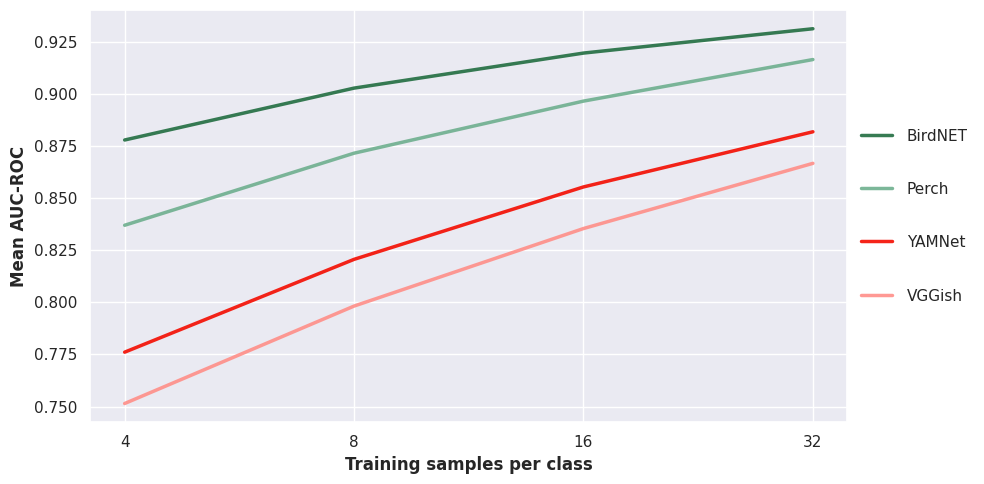

In [119]:
#@title Pretrained models
embedding_properties = {
    # Pretrained models
    'birdnet': {'name': 'BirdNET', 'line_style': '-', 'color': '#216d40', 'ignore': False, 'order': 1},
    'perch': {'name': 'Perch', 'line_style': '-', 'color': '#6eaf8e', 'ignore': False, 'order': 2},
    'yamnet': {'name': 'YAMNet', 'line_style': '-', 'color': '#f40c00', 'ignore': False, 'order': 3},
    'vggish': {'name': 'VGGish', 'line_style': '-', 'color': '#ff8e88', 'ignore': False, 'order': 4},

    # Exploring settings
    'perch_baselin_head': {'name': 'Perch (from head)', 'line_style': '-', 'color': 'orange', 'ignore': True},
    'perch_new': {'name': 'Perch New', 'line_style': '-', 'color': 'brown', 'ignore': True},
    'perch_200kstep_256bs': {'name': 'Perch New 200kstep 256batch', 'line_style': '-', 'color': 'pink', 'ignore': True},
    'perch_1mstep_128bs': {'name': 'Perch New 1Mkstep 128batch', 'line_style': '-', 'color': 'cyan', 'ignore': True},
    'perch_1m': {'name': 'Perch New 1Mstep 256batch', 'line_style': '-', 'color': 'magenta', 'ignore': True},
    'FSD50K_80birdweight': {'name': 'FSD50K 80birdweight', 'line_style': '-', 'color': 'lime', 'ignore': True},
    'FSD50k_1M': {'name': 'FSD50K 1M', 'line_style': '-', 'color': 'yellow', 'ignore': True},

    # PCEN settings
    'perch_pcen_basic': {'name': 'Perch PCEN Basic', 'line_style': '-', 'color': 'blue', 'ignore': True},
    'perch_pcen_new': {'name': 'Perch PCEN New', 'line_style': '-', 'color': 'green', 'ignore': True},
    'perch_pcen_bio': {'name': 'Perch PCEN BIO', 'line_style': '-', 'color': 'red', 'ignore': True},

    # Model trained on reef data with bird and fsd50k mixed in
    'Reef': {'name': 'Reef', 'line_style': '-', 'color': 'teal', 'ignore': True},
    'ReefPerch': {'name': 'Reef-Bird', 'line_style': '-', 'color': 'grey', 'ignore': True},
    'BirdReefFSD50k': {'name': 'Bird-Reef-FSD50k', 'line_style': '-', 'color': 'navy', 'ignore': True},
    'FSD50k_1M_128_newpcen': {'name': 'ReefPerch', 'line_style': '--', 'color': 'navy', 'ignore': True},
}
plot_auc_roc_by_embedding(results, embeddings_to_plot, embedding_properties)


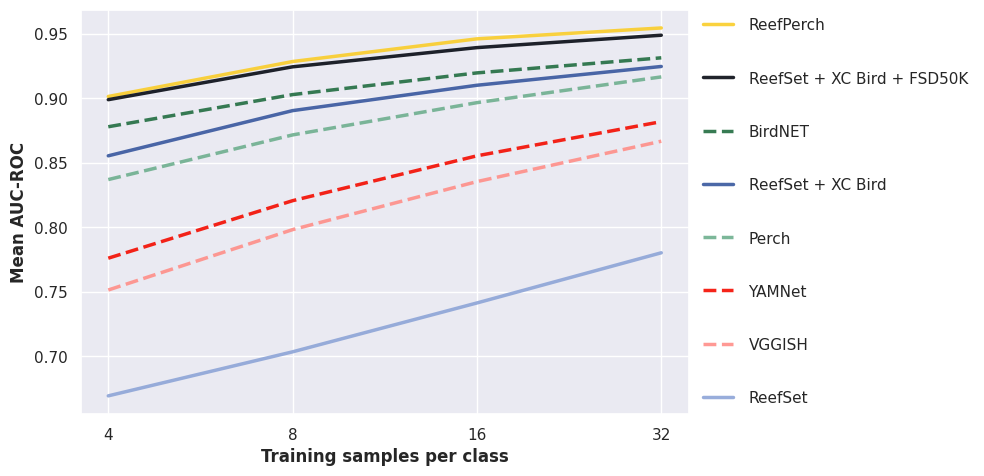

In [120]:
#@title Our models
embedding_properties = {
    # Pretrained models
    'birdnet': {'name': 'BirdNET', 'line_style': '--', 'color': '#216d40', 'ignore': False, 'order': 2},
    'perch': {'name': 'Perch', 'line_style': '--', 'color': '#6eaf8e', 'ignore': False, 'order': 4},
    'yamnet': {'name': 'YAMNet', 'line_style': '--', 'color': '#f40c00', 'ignore': False, 'order': 5},
    'vggish': {'name': 'VGGISH', 'line_style': '--', 'color': '#ff8e88', 'ignore': False, 'order': 6},

    # Exploring settings
    'perch_baselin_head': {'name': 'Perch (from head)', 'line_style': '-', 'color': 'orange', 'ignore': True},
    'perch_new': {'name': 'Perch New', 'line_style': '-', 'color': 'brown', 'ignore': True},
    'perch_200kstep_256bs': {'name': 'Perch New 200kstep 256batch', 'line_style': '-', 'color': 'pink', 'ignore': True},
    'perch_1mstep_128bs': {'name': 'Perch New 1Mkstep 128batch', 'line_style': '-', 'color': 'cyan', 'ignore': True},
    'perch_1m': {'name': 'Perch New 1Mstep 256batch', 'line_style': '-', 'color': 'magenta', 'ignore': True},
    'FSD50K_80birdweight': {'name': 'FSD50K 80birdweight', 'line_style': '-', 'color': 'lime', 'ignore': True},
    'FSD50k_1M': {'name': 'FSD50K 1M', 'line_style': '-', 'color': 'yellow', 'ignore': True},

    # PCEN settings
    'perch_pcen_basic': {'name': 'Perch PCEN Basic', 'line_style': '-', 'color': 'blue', 'ignore': True},
    'perch_pcen_new': {'name': 'Perch PCEN New', 'line_style': '-', 'color': 'green', 'ignore': True},
    'perch_pcen_bio': {'name': 'Perch PCEN BIO', 'line_style': '-', 'color': 'red', 'ignore': True},

    # Model trained on reef data with bird and fsd50k mixed in
    'Reef': {'name': 'ReefSet', 'line_style': '-', 'color': '#8da4d7', 'ignore': False, 'order': 7},
    'ReefPerch': {'name': 'ReefSet + XC Bird', 'line_style': '-', 'color': '#37579e', 'ignore': False, 'order': 3},
    'BirdReefFSD50k': {'name': 'ReefSet + XC Bird + FSD50K', 'line_style': '-', 'color':'#070b14', 'ignore': False, 'order': 1},
    'FSD50k_1M_128_newpcen': {'name': 'ReefPerch', 'line_style': '-', 'color': '#FACD29', 'ignore': False, 'order': 0},
}
plot_auc_roc_by_embedding(results, embeddings_to_plot, embedding_properties)


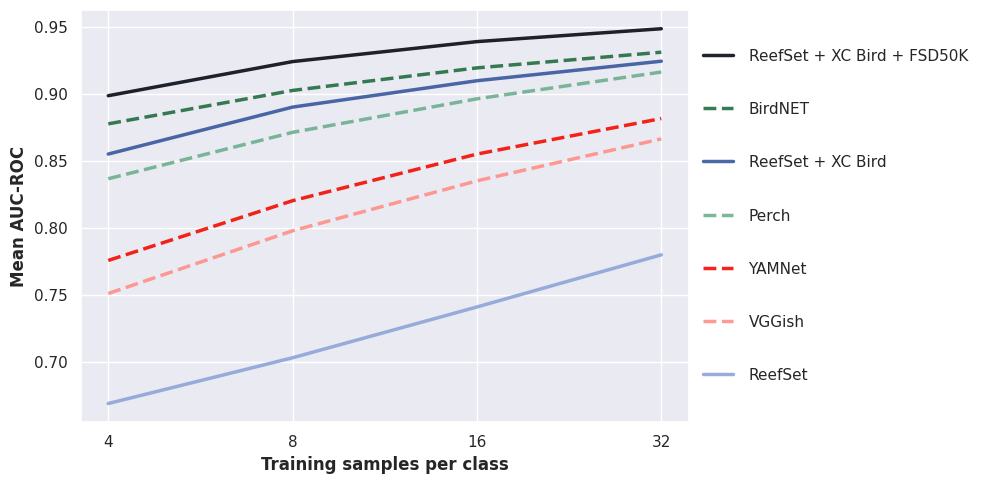

In [121]:
embedding_properties = {
    # Pretrained models
    'birdnet': {'name': 'BirdNET', 'line_style': '--', 'color': '#216d40', 'ignore': False, 'order': 2},
    'perch': {'name': 'Perch', 'line_style': '--', 'color': '#6eaf8e', 'ignore': False, 'order': 4},
    'yamnet': {'name': 'YAMNet', 'line_style': '--', 'color': '#f40c00', 'ignore': False, 'order': 5},
    'vggish': {'name': 'VGGish', 'line_style': '--', 'color': '#ff8e88', 'ignore': False, 'order': 6},

    # Exploring settings
    'perch_baselin_head': {'name': 'Perch (from head)', 'line_style': '-', 'color': 'orange', 'ignore': True},
    'perch_new': {'name': 'Perch New', 'line_style': '-', 'color': 'brown', 'ignore': True},
    'perch_200kstep_256bs': {'name': 'Perch New 200kstep 256batch', 'line_style': '-', 'color': 'pink', 'ignore': True},
    'perch_1mstep_128bs': {'name': 'Perch New 1Mkstep 128batch', 'line_style': '-', 'color': 'cyan', 'ignore': True},
    'perch_1m': {'name': 'Perch New 1Mstep 256batch', 'line_style': '-', 'color': 'magenta', 'ignore': True},
    'FSD50K_80birdweight': {'name': 'FSD50K 80birdweight', 'line_style': '-', 'color': 'lime', 'ignore': True},
    'FSD50k_1M': {'name': 'FSD50K 1M', 'line_style': '-', 'color': 'yellow', 'ignore': True},

    # PCEN settings
    'perch_pcen_basic': {'name': 'Perch PCEN Basic', 'line_style': '-', 'color': 'blue', 'ignore': True},
    'perch_pcen_new': {'name': 'Perch PCEN New', 'line_style': '-', 'color': 'green', 'ignore': True},
    'perch_pcen_bio': {'name': 'Perch PCEN BIO', 'line_style': '-', 'color': 'red', 'ignore': True},

    # Model trained on reef data with bird and fsd50k mixed in
    'Reef': {'name': 'ReefSet', 'line_style': '-', 'color': '#8da4d7', 'ignore': False, 'order': 7},
    'ReefPerch': {'name': 'ReefSet + XC Bird', 'line_style': '-', 'color': '#37579e', 'ignore': False, 'order': 3},
    'BirdReefFSD50k': {'name': 'ReefSet + XC Bird + FSD50K', 'line_style': '-', 'color':'#070b14', 'ignore': False, 'order': 1},
    'FSD50k_1M_128_newpcen': {'name': 'ReefPerch', 'line_style': '--', 'color': 'navy', 'ignore': True},
}
plot_auc_roc_by_embedding(results, embeddings_to_plot, embedding_properties)


# Printing raw values

In [39]:
import json
import pandas as pd
import os
from etils import epath

# Path to folder where results are stored
base_dir = os.getenv('BASE_DIR')
if not base_dir:
    raise ValueError("BASE_DIR environment variable is not set.")

directory = os.path.join(base_dir, 'ucl_perch/other/pretraining_results_files')
directory = epath.Path(directory)

# Define the embedding properties as given before
#@title Our models
embedding_properties = {
    # Pretrained models
    'birdnet': {'name': 'BirdNET', 'line_style': '--', 'color': '#216d40', 'ignore': False, 'order': 2},
    'perch': {'name': 'Perch', 'line_style': '--', 'color': '#6eaf8e', 'ignore': False, 'order': 4},
    'yamnet': {'name': 'YAMNet', 'line_style': '--', 'color': '#f40c00', 'ignore': False, 'order': 5},
    'vggish': {'name': 'VGGISH', 'line_style': '--', 'color': '#ff8e88', 'ignore': False, 'order': 6},

    # Exploring settings
    'perch_baselin_head': {'name': 'Perch (from head)', 'line_style': '-', 'color': 'orange', 'ignore': True},
    'perch_new': {'name': 'Perch New', 'line_style': '-', 'color': 'brown', 'ignore': True},
    'perch_200kstep_256bs': {'name': 'Perch New 200kstep 256batch', 'line_style': '-', 'color': 'pink', 'ignore': True},
    'perch_1mstep_128bs': {'name': 'Perch New 1Mkstep 128batch', 'line_style': '-', 'color': 'cyan', 'ignore': True},
    'perch_1m': {'name': 'Perch New 1Mstep 256batch', 'line_style': '-', 'color': 'magenta', 'ignore': True},
    'FSD50K_80birdweight': {'name': 'FSD50K 80birdweight', 'line_style': '-', 'color': 'lime', 'ignore': True},
    'FSD50k_1M': {'name': 'FSD50K 1M', 'line_style': '-', 'color': 'yellow', 'ignore': True},

    # PCEN settings
    'perch_pcen_basic': {'name': 'Perch PCEN Basic', 'line_style': '-', 'color': 'blue', 'ignore': True},
    'perch_pcen_new': {'name': 'Perch PCEN New', 'line_style': '-', 'color': 'green', 'ignore': True},
    'perch_pcen_bio': {'name': 'Perch PCEN BIO', 'line_style': '-', 'color': 'red', 'ignore': True},

    # Model trained on reef data with bird and fsd50k mixed in
    'Reef': {'name': 'ReefSet', 'line_style': '-', 'color': '#8da4d7', 'ignore': False, 'order': 7},
    'ReefPerch': {'name': 'ReefSet + XC Bird', 'line_style': '-', 'color': '#37579e', 'ignore': False, 'order': 3},
    'BirdReefFSD50k': {'name': 'ReefSet + XC Bird + FSD50K', 'line_style': '-', 'color':'#070b14', 'ignore': False, 'order': 1},
    'FSD50k_1M_128_newpcen': {'name': 'ReefPerch', 'line_style': '-', 'color': '#FACD29', 'ignore': False, 'order': 0},
}

# Initialize a dictionary to store results
results = []

# Iterate over all JSON files in the directory
for json_file in directory.glob('*.json'):
    json_path = epath.Path(json_file)
    with json_path.open() as f:
        config_data = json.load(f)

    embedding_used = config_data.get('embedding_used', '')
    example_per_class = config_data.get('example_per_class', '')

    timestamp = json_path.stem.split('_')[-2:]
    timestamp = '_'.join(timestamp)
    csv_files = list(directory.glob(f'*_results_{timestamp}.csv'))
    if not csv_files:
        raise FileNotFoundError(f"No CSV file found with timestamp {timestamp}")
    csv_file = csv_files[0]

    df = pd.read_csv(csv_file)
    mean_auc_roc = df['mean_auc_roc'].mean()
    std_auc_roc = df['mean_auc_roc'].std()

    results.append({
        'embedding_used': embedding_used,
        'example_per_class': example_per_class,
        'mean_auc_roc': mean_auc_roc,
        'std_auc_roc': std_auc_roc
    })

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Print mean and standard deviation of AUC ROC for each model and each training sample count
for embedding, props in embedding_properties.items():
    # check if we want this embedding to be ignore
    if not props.get('ignore', False):
        print(f"\n{props.get('name', embedding)}:")
        for sample_count in sorted(results_df['example_per_class'].unique()):
            subset = results_df[(results_df['embedding_used'] == embedding) & 
                                (results_df['example_per_class'] == sample_count)]
            if not subset.empty:  # Make sure the subset is not empty
                mean_auc = subset['mean_auc_roc'].iloc[0]  # Get the first value
                std_auc = subset['std_auc_roc'].iloc[0]  # Get the first value
                print(f"{sample_count} training samples per class: Mean AUC ROC = {mean_auc:.2f}, Std Dev = {std_auc:.2f}")
            else:
                print(f"{sample_count} training samples per class: Mean AUC ROC and Std Dev are not available.")

        # Print overall mean and standard deviation for the embedding
        overall_mean = results_df[results_df['embedding_used'] == embedding]['mean_auc_roc'].mean()
        overall_std = results_df[results_df['embedding_used'] == embedding]['mean_auc_roc'].std()
        print(f"Overall mean AUC ROC = {overall_mean:.5f},  Std Dev = {overall_std:.5f}")


BirdNET:
4 training samples per class: Mean AUC ROC = 0.88, Std Dev = 0.09
8 training samples per class: Mean AUC ROC = 0.90, Std Dev = 0.07
16 training samples per class: Mean AUC ROC = 0.92, Std Dev = 0.06
32 training samples per class: Mean AUC ROC = 0.93, Std Dev = 0.06
Overall mean AUC ROC = 0.90810,  Std Dev = 0.02320

Perch:
4 training samples per class: Mean AUC ROC = 0.84, Std Dev = 0.11
8 training samples per class: Mean AUC ROC = 0.87, Std Dev = 0.09
16 training samples per class: Mean AUC ROC = 0.90, Std Dev = 0.08
32 training samples per class: Mean AUC ROC = 0.92, Std Dev = 0.06
Overall mean AUC ROC = 0.88057,  Std Dev = 0.03434

YAMNet:
4 training samples per class: Mean AUC ROC = 0.78, Std Dev = 0.10
8 training samples per class: Mean AUC ROC = 0.82, Std Dev = 0.09
16 training samples per class: Mean AUC ROC = 0.86, Std Dev = 0.09
32 training samples per class: Mean AUC ROC = 0.88, Std Dev = 0.08
Overall mean AUC ROC = 0.83359,  Std Dev = 0.04580

VGGISH:
4 training sa

In [62]:
# AUC-ROC values
auc_roc_dataset1 = 0.92802 # lower value here
auc_roc_dataset2 = 0.93277 # higher value here

# Errors
error_dataset1 = 1 - auc_roc_dataset1
error_dataset2 = 1 - auc_roc_dataset2

# Difference in error
difference_in_error = abs(error_dataset1 - error_dataset2)

print(f"Error for the first dataset: {error_dataset1}")
print(f"Error for the second dataset: {error_dataset2}")
print()
print(f"Difference in error: {difference_in_error}")

# Absolute Difference
absolute_difference = error_dataset1 - error_dataset2

# Percentage Change from dataset1 to dataset2
percentage_change = ((error_dataset2 - error_dataset1) / error_dataset1) * 100

# Ratio
error_ratio = error_dataset1 / error_dataset2

# Fold Change
fold_change = error_dataset2 / error_dataset1

print(f"Absolute Difference: {absolute_difference:.4f}")
print(f"Percentage Change: {percentage_change:.2f}%")
print(f"Ratio of Errors: {error_ratio:.4f}")
print(f"Fold Change: {fold_change:.2f} times")



Error for the first dataset: 0.07198000000000004
Error for the second dataset: 0.06723000000000001

Difference in error: 0.004750000000000032
Absolute Difference: 0.0048
Percentage Change: -6.60%
Ratio of Errors: 1.0707
Fold Change: 0.93 times


# Results fig 2 + supplementary

This uses embedding_properties set above

In [8]:
#@title Our models
embedding_properties = {
    # Pretrained models
    'birdnet': {'name': 'BirdNet', 'line_style': '--', 'color': '#216d40', 'ignore': False, 'order': 2},
    'perch': {'name': 'Perch', 'line_style': '--', 'color': '#6eaf8e', 'ignore': False, 'order': 3},
    'yamnet': {'name': 'YamNet', 'line_style': '--', 'color': '#f40c00', 'ignore': False, 'order': 5},
    'vggish': {'name': 'VGGISH', 'line_style': '--', 'color': '#ff8e88', 'ignore': False, 'order': 6},

    # Exploring settings
    'perch_baselin_head': {'name': 'Perch (from head)', 'line_style': '-', 'color': 'orange', 'ignore': True, 'order': 8},
    'perch_new': {'name': 'Perch New', 'line_style': '-', 'color': 'brown', 'ignore': True, 'order': 9},
    'perch_200kstep_256bs': {'name': 'Perch New 200kstep 256batch', 'line_style': '-', 'color': 'pink', 'ignore': True, 'order': 10},
    'perch_1mstep_128bs': {'name': 'Perch New 1Mkstep 128batch', 'line_style': '-', 'color': 'cyan', 'ignore': True, 'order': 11},
    'perch_1m': {'name': 'Perch New 1Mstep 256batch', 'line_style': '-', 'color': 'magenta', 'ignore': True, 'order': 12},
    'FSD50K_80birdweight': {'name': 'FSD50K 80birdweight', 'line_style': '-', 'color': 'lime', 'ignore': True, 'order': 13},
    'FSD50k_1M': {'name': 'FSD50K 1M', 'line_style': '-', 'color': 'yellow', 'ignore': True, 'order': 14},

    # PCEN settings
    'perch_pcen_basic': {'name': 'Perch PCEN Basic', 'line_style': '-', 'color': 'blue', 'ignore': True, 'order': 15},
    'perch_pcen_new': {'name': 'Perch PCEN New', 'line_style': '-', 'color': 'green', 'ignore': True, 'order': 16},
    'perch_pcen_bio': {'name': 'Perch PCEN BIO', 'line_style': '-', 'color': 'red', 'ignore': True, 'order': 17},

    # Model trained on reef data with bird and fsd50k mixed in
    'Reef': {'name': 'Reef', 'line_style': '-', 'color': '#8da4d7', 'ignore': False, 'order': 7},
    'ReefPerch': {'name': 'ReefBird', 'line_style': '-', 'color': '#37579e', 'ignore': False, 'order': 3},
    'BirdReefFSD50k': {'name': 'ReefBirdFSD50k', 'line_style': '-', 'color':'#070b14', 'ignore': False, 'order': 1},
    'FSD50k_1M_128_newpcen': {'name': 'BirdReefFSD50k', 'line_style': '--', 'color': 'navy', 'ignore': True, 'order': 18}}

['BirdReefFSD50k', 'birdnet', 'perch', 'ReefPerch', 'yamnet', 'vggish', 'Reef']


<Figure size 2000x900 with 0 Axes>

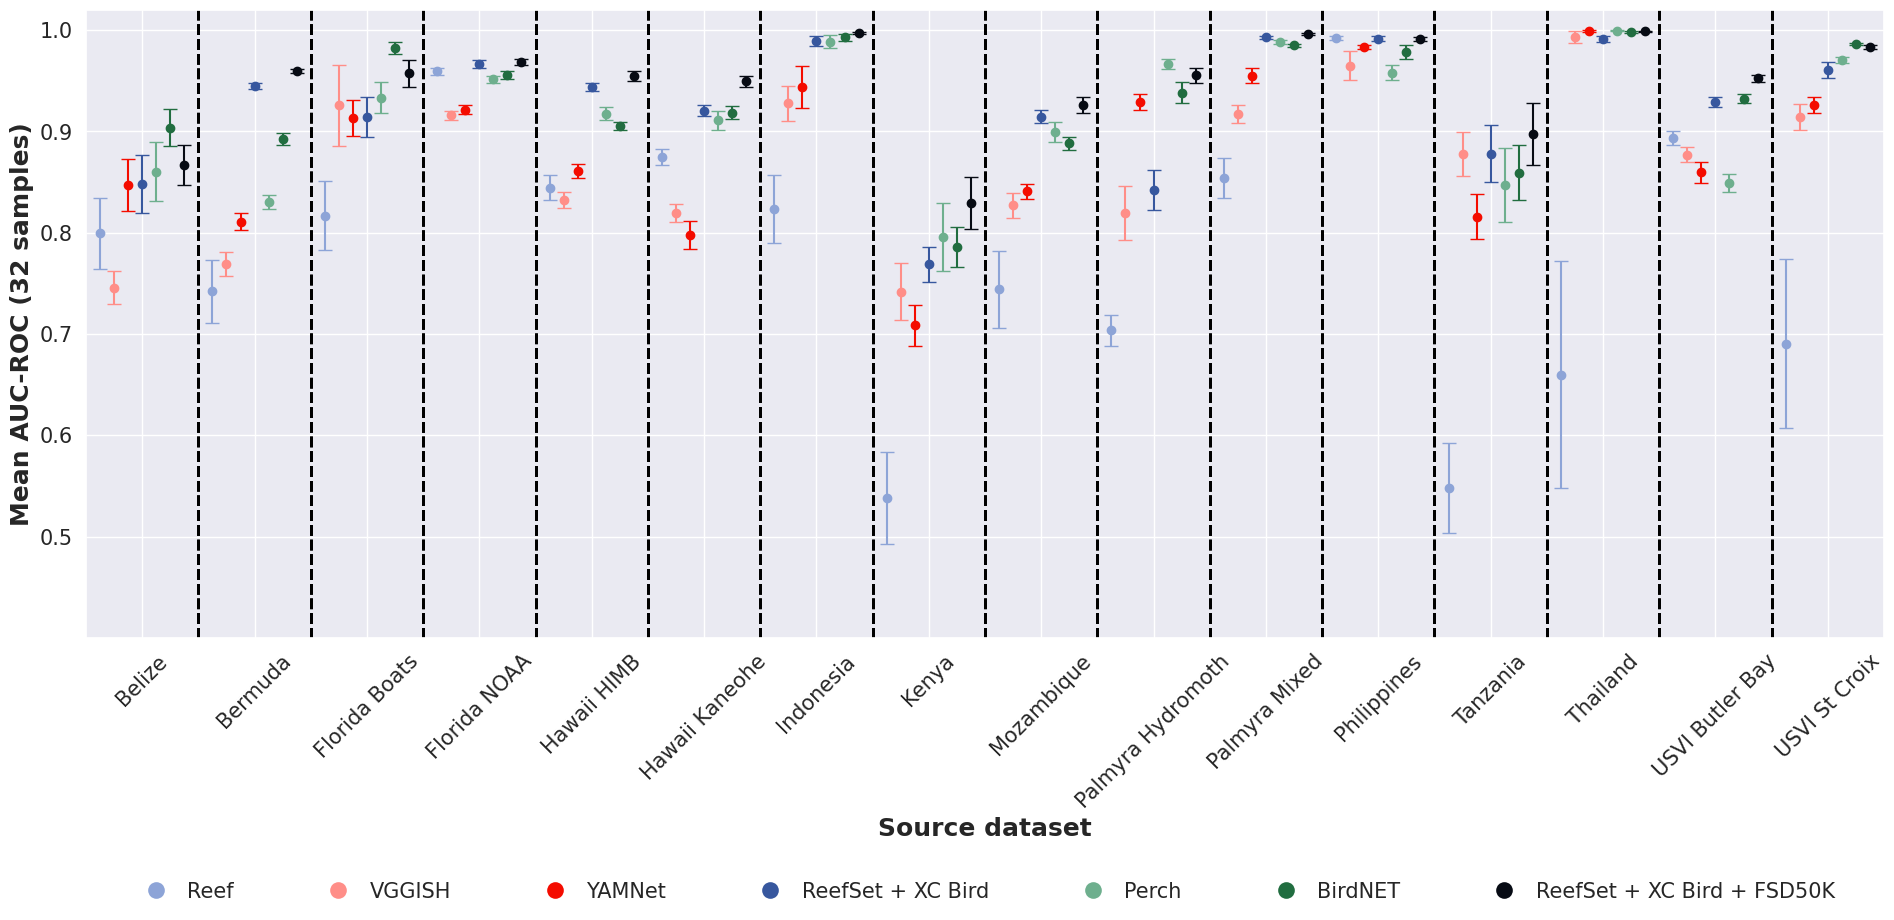

In [114]:
embedding_properties = {
    # Pretrained models
    'birdnet': {'name': 'BirdNet', 'line_style': '--', 'color': '#216d40', 'ignore': False, 'order': 2},
    'perch': {'name': 'Perch', 'line_style': '--', 'color': '#6eaf8e', 'ignore': False, 'order': 3},
    'yamnet': {'name': 'YamNet', 'line_style': '--', 'color': '#f40c00', 'ignore': False, 'order': 5},
    'vggish': {'name': 'VGGISH', 'line_style': '--', 'color': '#ff8e88', 'ignore': False, 'order': 6},

    # Exploring settings
    'perch_baselin_head': {'name': 'Perch (from head)', 'line_style': '-', 'color': 'orange', 'ignore': True, 'order': 8},
    'perch_new': {'name': 'Perch New', 'line_style': '-', 'color': 'brown', 'ignore': True, 'order': 9},
    'perch_200kstep_256bs': {'name': 'Perch New 200kstep 256batch', 'line_style': '-', 'color': 'pink', 'ignore': True, 'order': 10},
    'perch_1mstep_128bs': {'name': 'Perch New 1Mkstep 128batch', 'line_style': '-', 'color': 'cyan', 'ignore': True, 'order': 11},
    'perch_1m': {'name': 'Perch New 1Mstep 256batch', 'line_style': '-', 'color': 'magenta', 'ignore': True, 'order': 12},
    'FSD50K_80birdweight': {'name': 'FSD50K 80birdweight', 'line_style': '-', 'color': 'lime', 'ignore': True, 'order': 13},
    'FSD50k_1M': {'name': 'FSD50K 1M', 'line_style': '-', 'color': 'yellow', 'ignore': True, 'order': 14},

    # PCEN settings
    'perch_pcen_basic': {'name': 'Perch PCEN Basic', 'line_style': '-', 'color': 'blue', 'ignore': True, 'order': 15},
    'perch_pcen_new': {'name': 'Perch PCEN New', 'line_style': '-', 'color': 'green', 'ignore': True, 'order': 16},
    'perch_pcen_bio': {'name': 'Perch PCEN BIO', 'line_style': '-', 'color': 'red', 'ignore': True, 'order': 17},

    # Model trained on reef data with bird and fsd50k mixed in
    'Reef': {'name': 'Reef', 'line_style': '-', 'color': '#8da4d7', 'ignore': False, 'order': 7},
    'ReefPerch': {'name': 'ReefBird', 'line_style': '-', 'color': '#37579e', 'ignore': False, 'order': 3},
    'BirdReefFSD50k': {'name': 'ReefBirdFSD50k', 'line_style': '-', 'color':'#070b14', 'ignore': False, 'order': 1},
    'FSD50k_1M_128_newpcen': {'name': 'BirdReefFSD50k', 'line_style': '--', 'color': 'navy', 'ignore': True, 'order': 18}}
    
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import numpy as np
from matplotlib.lines import Line2D  # Import necessary for custom legend handles


# Directory where results are stored
directory = os.path.join(base_dir,'ucl_perch/other/pretraining_results_files') #@param
directory = epath.Path(directory)

# Mapping of region names to display names
region_name_mapping = {
    'belize': 'Belize',
    'bermuda': 'Bermuda',
    'florida_boats': 'Florida Boats',
    'florida_cmi': 'Florida NOAA',
    'hawaii_himb': 'Hawaii HIMB',
    'hawaii_kaneohe': 'Hawaii Kaneohe',
    'indonesia_bombs': 'Indonesia',
    'kenya': 'Kenya',
    'mozambique': 'Mozambique',
    'palmyra_hydromoth': 'Palmyra Hydromoth',
    'palmyra_other': 'Palmyra Mixed',
    'philippines_cmi': 'Philippines',
    'tanzania': 'Tanzania',
    'thailand': 'Thailand',
    'usvi_butler-bay': 'USVI Butler Bay',
    'usvi_stcroix': 'USVI St Croix'
}

embedding_name_mapping = {
    'Reef': 'Reef',
    'VGGish': 'VGGish',
    'YamNet': 'YAMNet',
    'ReefBird': 'ReefSet + XC Bird',
    'Perch': 'Perch',
    'BirdNet': 'BirdNET',
    'ReefBirdFSD50k': 'ReefSet + XC Bird + FSD50K',
}

# Function to load results
def load_results(directory, example_per_class_filter):
    results = []
    for json_file in directory.glob('*.json'):
        with json_file.open() as f:
            config_data = json.load(f)
        
        # Filter by example_per_class
        if config_data['example_per_class'] != example_per_class_filter:
            continue
        
        # Extract the timestamp from the JSON file name for matching with CSV
        timestamp = json_file.stem.split('_')[-2:]
        timestamp = '_'.join(timestamp)

        # Match CSV file using the extracted timestamp
        csv_files = list(directory.glob(f'*_results_by_seed_{timestamp}.csv'))
        if not csv_files:
            print(f"No CSV file found with timestamp {timestamp}")
            continue
        csv_file = csv_files[0]  # Assuming the first matching CSV is the correct one

        # Process each matching CSV file
        df = pd.read_csv(csv_file)
        for region in df['region'].unique():
            region_df = df[df['region'] == region]
            mean_auc_roc = region_df['auc_roc'].mean()
            std_auc_roc = region_df['auc_roc'].std()
            results.append({
                'embedding_used': config_data['embedding_used'],
                'example_per_class': config_data['example_per_class'],
                'region': region,
                'mean_auc_roc': mean_auc_roc,
                'std_auc_roc': std_auc_roc
            })
    return results




# Plotting function with adjusted x-axis limits
def plot_results_by_region(results, embeddings_to_plot, embedding_properties, example_per_class_filter, gap_between_regions=2):
    sns.set(style="darkgrid")
    plt.figure(figsize=(20, 9))
    
    # load data, then map names
    results_df = pd.DataFrame(results)
    results_df['region'] = results_df['region'].map(region_name_mapping).fillna(results_df['region'])

    # Determine unique regions and calculate positions
    regions = sorted(results_df['region'].unique())
    num_models = len([emb for emb in embeddings_to_plot if not embedding_properties[emb].get('ignore', False)])
    total_gap = gap_between_regions * (len(regions) - 1)
    region_width = (1 - total_gap) / len(regions)
    model_spacing = region_width / num_models
    
    plt.figure(figsize=(20, 10))

    model_orders = {emb: embedding_properties[emb]['order'] for emb in embeddings_to_plot if not embedding_properties[emb].get('ignore', False)}
    sorted_models = sorted(model_orders, key=model_orders.get, reverse=False)
    print(sorted_models)


    # Initialize variables to track the min and max positions for setting x-axis limits
    min_pos = float('inf')
    max_pos = float('-inf')

    for i, region in enumerate(regions):
        for j, embedding in enumerate(sorted_models):
            properties = embedding_properties.get(embedding, {})
            if properties.get('ignore', True): continue

            subset = results_df[(results_df['embedding_used'] == embedding) & (results_df['region'] == region)]
            if subset.empty: continue

            pos = i + (j * model_spacing) + (model_spacing / 2) * (1 - num_models)
            min_pos = min(min_pos, pos)
            max_pos = max(max_pos, pos)

            mean_auc_roc = subset['mean_auc_roc'].values[0]
            std_auc_roc = subset['std_auc_roc'].values[0]

            # Adjust stdev to ensure the error bar does not exceed 1.0
            upper_limit = min(mean_auc_roc + std_auc_roc, 1.0)
            adjusted_std_auc_roc = upper_limit - mean_auc_roc

            color = properties.get('color', 'grey')
            label = properties.get('name', embedding) if i == 0 else None

            plt.errorbar(pos, mean_auc_roc, yerr=adjusted_std_auc_roc, fmt='o', color=color, label=label, capsize=5)

            if i < len(regions) - 1:
                line_pos = i + 1 - (gap_between_regions / 2)
                plt.axvline(x=line_pos, color='black', linestyle='--', linewidth=2)

    plt.xticks([i for i, _ in enumerate(regions)], regions, rotation=45, fontsize=15)
    y_ticks = np.arange(0.5, 1.1, 0.1)
    plt.yticks(y_ticks, [f"{tick:.1f}" for tick in y_ticks], fontsize=15)
    plt.ylabel(f"Mean AUC-ROC ({example_per_class_filter} samples)", fontsize=18, fontweight='bold')
    plt.xlabel("Source dataset", fontsize=18, fontweight='bold')

    # Adjusting the legend
    handles, labels = plt.gca().get_legend_handles_labels()
    mapped_labels = [embedding_name_mapping.get(label, label) for label in labels]
    handles, mapped_labels = handles[::-1], mapped_labels[::-1]

    # Modify the creation of custom_legend_handles to remove the black outline
    custom_legend_handles = [Line2D([0], [0], marker='o', color='none', label=label,
                                    markerfacecolor=color, markeredgecolor='none', markersize=12)  # Set markeredgecolor to 'none'
                            for color, label in zip([embedding_properties[emb]['color'] for emb in sorted_models[::-1]], 
                                                    [embedding_properties[emb]['name'] for emb in sorted_models[::-1]])]

    # Then, use these handles when creating the legend
    legend = plt.legend(custom_legend_handles, mapped_labels, loc='lower center', bbox_to_anchor=(0.5, -0.45),
                        ncol=len(custom_legend_handles), handletextpad=0.5, columnspacing=4,
                        frameon=False, fontsize=15)

    # The rest of your plotting code remains unchanged
    plt.setp(legend.get_title(), fontsize='large')  # If you want to adjust the legend title size

    # Adjust the x-axis limits to reduce blank space
    plt.xlim(min_pos - (model_spacing + 0.25), max_pos + (model_spacing + 0.25))
    plt.ylim(0.4, 1.02)


    plt.tight_layout()
    plt.show()



# Example usage
example_per_class_filter = 32
results = load_results(directory, example_per_class_filter)
plot_results_by_region(results, embeddings_to_plot, embedding_properties, example_per_class_filter, gap_between_regions=1)



# Results fig 2

The combined auc-roc acorss all 4 training sample counts

['BirdReefFSD50k', 'birdnet', 'perch', 'ReefPerch', 'yamnet', 'vggish', 'Reef']


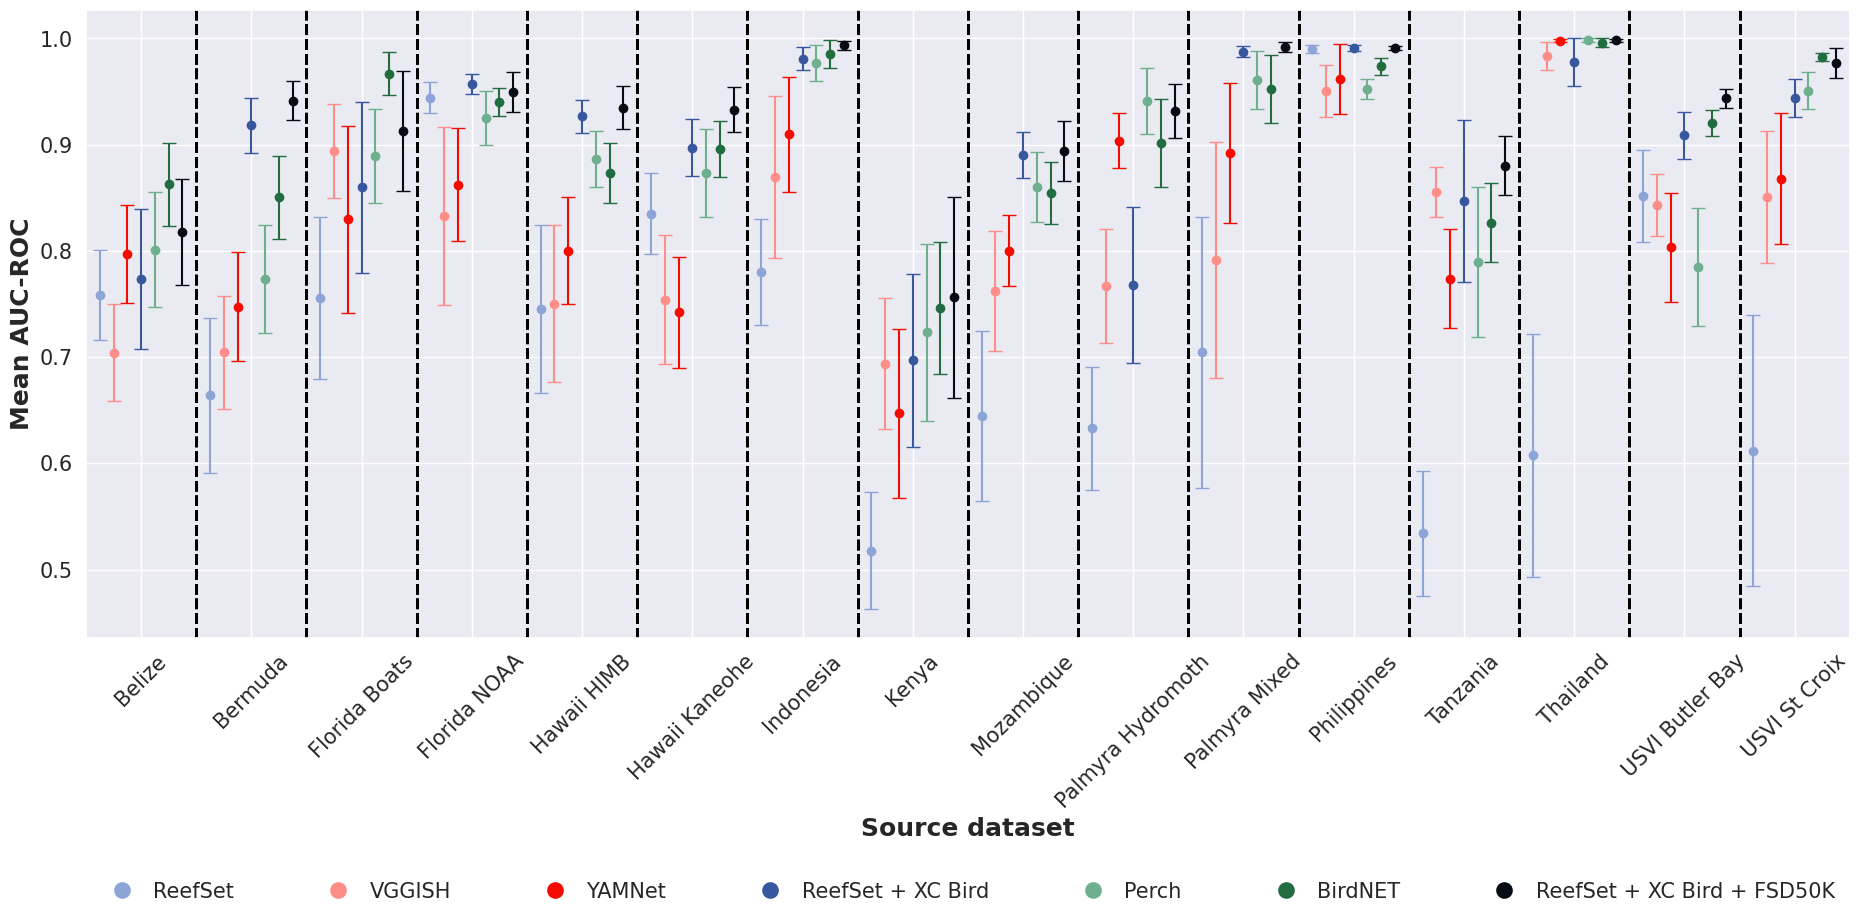

In [92]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import numpy as np
from matplotlib.lines import Line2D  # Import necessary for custom legend handles


# Directory where results are stored
directory = os.path.join(base_dir,'ucl_perch/other/pretraining_results_files') #@param
directory = epath.Path(directory)

# Mapping of region names to display names
region_name_mapping = {
    'belize': 'Belize',
    'bermuda': 'Bermuda',
    'florida_boats': 'Florida Boats',
    'florida_cmi': 'Florida NOAA',
    'hawaii_himb': 'Hawaii HIMB',
    'hawaii_kaneohe': 'Hawaii Kaneohe',
    'indonesia_bombs': 'Indonesia',
    'kenya': 'Kenya',
    'mozambique': 'Mozambique',
    'palmyra_hydromoth': 'Palmyra Hydromoth',
    'palmyra_other': 'Palmyra Mixed',
    'philippines_cmi': 'Philippines',
    'tanzania': 'Tanzania',
    'thailand': 'Thailand',
    'usvi_butler-bay': 'USVI Butler Bay',
    'usvi_stcroix': 'USVI St Croix'
}

embedding_name_mapping = {
    'Reef': 'ReefSet',
    'VGGish': 'VGGish',
    'YamNet': 'YAMNet',
    'ReefBird': 'ReefSet + XC Bird',
    'Perch': 'Perch',
    'BirdNet': 'BirdNET',
    'ReefBirdFSD50k': 'ReefSet + XC Bird + FSD50K',
}

# Function to load results
def load_results_aggregated(directory, example_per_class_filters):
    # Initialize a dictionary to hold intermediate aggregation results
    intermediate_results = {}

    for example_per_class in example_per_class_filters:
        for json_file in directory.glob('*.json'):
            with json_file.open() as f:
                config_data = json.load(f)

            if config_data['example_per_class'] not in example_per_class_filters:
                continue

            timestamp = json_file.stem.split('_')[-2:]
            timestamp = '_'.join(timestamp)

            csv_files = list(directory.glob(f'*_results_by_seed_{timestamp}.csv'))
            if not csv_files:
                print(f"No CSV file found with timestamp {timestamp}")
                continue
            csv_file = csv_files[0]

            df = pd.read_csv(csv_file)
            for region in df['region'].unique():
                key = (config_data['embedding_used'], region)

                if key not in intermediate_results:
                    intermediate_results[key] = []

                intermediate_results[key].extend(df[df['region'] == region]['auc_roc'].tolist())

    # Calculate overall mean and std for each embedding and region across all example_per_class values
    aggregated_results = []
    for (embedding, region), auc_rocs in intermediate_results.items():
        aggregated_results.append({
            'embedding_used': embedding,
            'region': region,
            'mean_auc_roc': np.mean(auc_rocs),
            'std_auc_roc': np.std(auc_rocs, ddof=1)  # ddof=1 for sample standard deviation
        })

    return aggregated_results



# Plotting function with adjusted x-axis limits
def plot_results_by_region(results, embeddings_to_plot, embedding_properties, gap_between_regions=2):
    sns.set(style="darkgrid")
    plt.figure(figsize=(20, 10))
    
    # load data, then map names
    results_df = pd.DataFrame(results)
    results_df['region'] = results_df['region'].map(region_name_mapping).fillna(results_df['region'])

    # Determine unique regions and calculate positions
    regions = sorted(results_df['region'].unique())
    num_models = len([emb for emb in embeddings_to_plot if not embedding_properties[emb].get('ignore', False)])
    total_gap = gap_between_regions * (len(regions) - 1)
    region_width = (1 - total_gap) / len(regions)
    model_spacing = region_width / num_models
    

    model_orders = {emb: embedding_properties[emb]['order'] for emb in embeddings_to_plot if not embedding_properties[emb].get('ignore', False)}
    sorted_models = sorted(model_orders, key=model_orders.get, reverse=False)
    print(sorted_models)


    # Initialize variables to track the min and max positions for setting x-axis limits
    min_pos = float('inf')
    max_pos = float('-inf')

    for i, region in enumerate(regions):
        for j, embedding in enumerate(sorted_models):
            properties = embedding_properties.get(embedding, {})
            if properties.get('ignore', True): continue

            subset = results_df[(results_df['embedding_used'] == embedding) & (results_df['region'] == region)]
            if subset.empty: continue

            pos = i + (j * model_spacing) + (model_spacing / 2) * (1 - num_models)
            min_pos = min(min_pos, pos)
            max_pos = max(max_pos, pos)

            mean_auc_roc = subset['mean_auc_roc'].values[0]
            std_auc_roc = subset['std_auc_roc'].values[0]

            # Adjust stdev to ensure the error bar does not exceed 1.0
            upper_limit = min(mean_auc_roc + std_auc_roc, 1.0)
            adjusted_std_auc_roc = upper_limit - mean_auc_roc

            color = properties.get('color', 'grey')
            label = properties.get('name', embedding) if i == 0 else None

            plt.errorbar(pos, mean_auc_roc, yerr=adjusted_std_auc_roc, fmt='o', color=color, label=label, capsize=5)

            if i < len(regions) - 1:
                line_pos = i + 1 - (gap_between_regions / 2)
                plt.axvline(x=line_pos, color='black', linestyle='--', linewidth=2)


    plt.xticks([i for i, _ in enumerate(regions)], regions, rotation=45, fontsize=15)
    plt.yticks(fontsize=15)
    plt.ylabel("Mean AUC-ROC", fontsize=18, fontweight='bold')
    plt.xlabel("Source dataset", fontsize=18, fontweight='bold')

    # Adjusting the legend
    handles, labels = plt.gca().get_legend_handles_labels()
    mapped_labels = [embedding_name_mapping.get(label, label) for label in labels]
    handles, mapped_labels = handles[::-1], mapped_labels[::-1]

    # Modify the creation of custom_legend_handles to remove the black outline
    custom_legend_handles = [Line2D([0], [0], marker='o', color='none', label=label,
                                    markerfacecolor=color, markeredgecolor='none', markersize=12)  # Set markeredgecolor to 'none'
                            for color, label in zip([embedding_properties[emb]['color'] for emb in sorted_models[::-1]], 
                                                    [embedding_properties[emb]['name'] for emb in sorted_models[::-1]])]

    # Then, use these handles when creating the legend
    legend = plt.legend(custom_legend_handles, mapped_labels, loc='lower center', bbox_to_anchor=(0.5, -0.45),
                        ncol=len(custom_legend_handles), handletextpad=0.5, columnspacing=4,
                        frameon=False, fontsize=15)

    # The rest of your plotting code remains unchanged
    plt.setp(legend.get_title(), fontsize='large')  # If you want to adjust the legend title size

    # Adjust the x-axis limits to reduce blank space
    plt.xlim(min_pos - (model_spacing + 0.25), max_pos + (model_spacing + 0.25))

    plt.tight_layout()
    plt.show()


# Example usage
example_per_class_filters = [4, 8, 16, 32]
results = load_results_aggregated(directory, example_per_class_filters)
plot_results_by_region(results, embeddings_to_plot, embedding_properties, gap_between_regions=1)



# Plotting datasets

/tmp/ipykernel_743/2937631743.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='label', y='count', data=merged_data, palette='viridis')


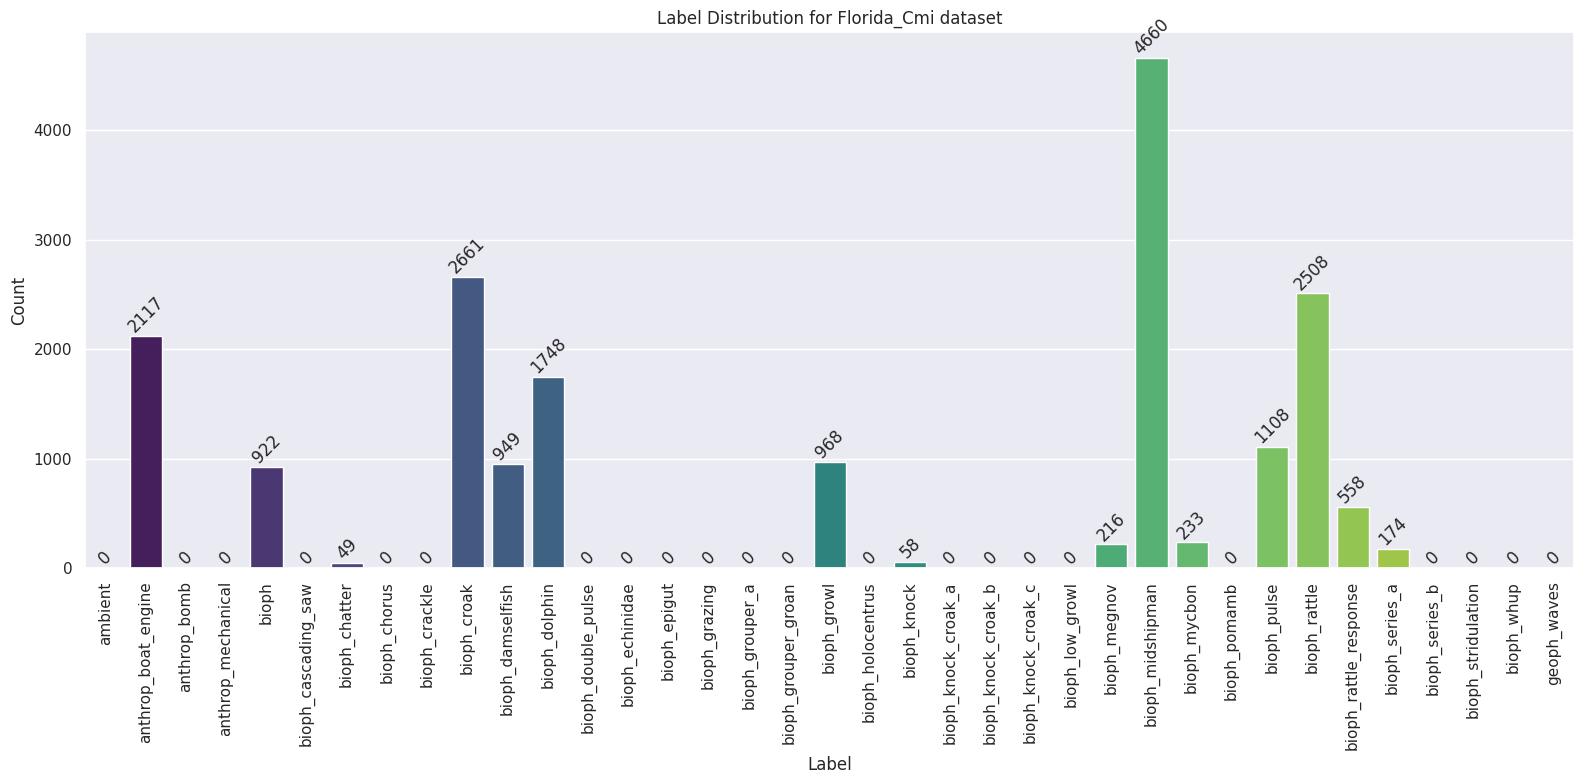

In [11]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load your dataset
file_path = os.path.join(base_dir,'ucl_perch/other/coral_reef_annotations.json')

# Set the seaborn theme
sns.set_theme(style="darkgrid")

# Load your dataset
df = pd.read_json(file_path)

def plot_label_distribution_for_region_all_classes_fixed(region):
    # Identify all unique labels across the dataset
    all_labels = pd.DataFrame(df['label'].unique(), columns=['label'])
    
    # Get counts of each label for the selected region
    region_data = df[df['region'] == region]
    region_label_counts = region_data.groupby('label').size().reset_index(name='count')
    
    # Merge to ensure all labels are included, filling missing values with 0
    merged_data = pd.merge(all_labels, region_label_counts, on='label', how='left').fillna(0)
    
    # Sort the DataFrame alphabetically by label before plotting
    merged_data = merged_data.sort_values(by='label')
    
    # Create the plot
    plt.figure(figsize=(16, 8))
    barplot = sns.barplot(x='label', y='count', data=merged_data, palette='viridis')
    
    # Add the raw values above the bars
    for p in barplot.patches:
        height = p.get_height()
        plt.text(p.get_x() + p.get_width() / 2., height + 0.1, '%d' % int(height), ha='center', va='bottom', rotation=45)

    plt.title(f'Label Distribution for {region.title()} dataset')
    plt.xlabel('Label')
    plt.ylabel('Count')
    plt.xticks(rotation=90)  # Rotate labels to 90 degrees if there are many labels
    plt.tight_layout()

# Example: Plot for "thailand" region with labels alphabetized
plot_label_distribution_for_region_all_classes_fixed('florida_cmi') ### CHOOSE REGION HERE
plt.show()


In [12]:
import pandas as pd

# Load your dataset
file_path = os.path.join(base_dir,'ucl_perch/other/coral_reef_annotations.json')
df = pd.read_json(file_path)

# Create a pivot table with labels as the index (rows) and regions as columns
pivot_table = df.pivot_table(index='label', columns='region', aggfunc='size', fill_value=0)

# Sort the rows (labels) alphabetically
pivot_table = pivot_table.reindex(sorted(pivot_table.index), axis=0)

# Export to CSV
output_path = os.path.join(base_dir,'ucl_perch/other/label_region_counts.csv')
pivot_table.to_csv(output_path)

# print("CSV file has been created:", output_path)
pivot_table


region,belize,bermuda,florida_boats,florida_cmi,hawaii_himb,hawaii_kaneohe,indonesia_bombs,kenya,mozambique,palmyra_hydromoth,palmyra_other,philippines_cmi,tanzania,thailand,usvi_butler-bay,usvi_stcroix
label,,,,,,,,,,,,,,,,
ambient,0,0,3528,0,0,0,1800,563,0,0,0,0,0,0,0,0
anthrop_boat_engine,0,397,1522,2117,476,64,0,0,0,0,0,94,0,244,193,0
anthrop_bomb,0,0,0,0,0,0,203,0,0,0,0,0,0,0,0,0
anthrop_mechanical,0,0,0,0,0,0,0,0,0,0,0,0,0,0,619,0
bioph,45,346,0,922,250,101,0,258,331,588,0,0,74,0,261,97
bioph_cascading_saw,0,0,0,0,68,195,0,0,0,1035,8166,0,0,0,0,0
bioph_chatter,0,0,0,49,0,0,0,0,0,106,0,0,0,0,0,0
bioph_chorus,63,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
bioph_crackle,203,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [13]:
# Initialize a dictionary to store the count of non-zero classes per region
non_zero_classes = {}
total_non_zero_entries = pivot_table.astype(bool).sum().sum()  # Total number of non-zero entries across the entire DataFrame

# Iterate over each column (region) to calculate the non-zero class counts
for region in pivot_table.columns:
    non_zero_classes[region] = pivot_table[region].astype(bool).sum()

# Initialize a variable to accumulate the proportions
total_proportion = 0

# Now, print out the number of non-zero classes (rows) for each region and their proportions as decimals
for region, count in non_zero_classes.items():
    proportion = count / total_non_zero_entries
    print(f"{region}: classes =  {count}, {proportion:.2f}")
    total_proportion += proportion

# Print the total proportion to verify it sums to 1 (or very close, accounting for floating-point precision)
print(f"\nThe sum of all proportions is: {total_proportion:.2f}")

# Check if the sum is close to 1, considering floating-point arithmetic precision
if round(total_proportion, 2) == 1.00:
    print("The proportions correctly sum up to 1.")
else:
    print("There is an issue with the proportions; they do not sum up to 1.")


belize: classes =  3, 0.04
bermuda: classes =  6, 0.08
florida_boats: classes =  2, 0.03
florida_cmi: classes =  15, 0.19
hawaii_himb: classes =  13, 0.17
hawaii_kaneohe: classes =  5, 0.06
indonesia_bombs: classes =  2, 0.03
kenya: classes =  2, 0.03
mozambique: classes =  6, 0.08
palmyra_hydromoth: classes =  3, 0.04
palmyra_other: classes =  8, 0.10
philippines_cmi: classes =  2, 0.03
tanzania: classes =  2, 0.03
thailand: classes =  2, 0.03
usvi_butler-bay: classes =  4, 0.05
usvi_stcroix: classes =  3, 0.04

The sum of all proportions is: 1.00
The proportions correctly sum up to 1.


# Dataset histogram

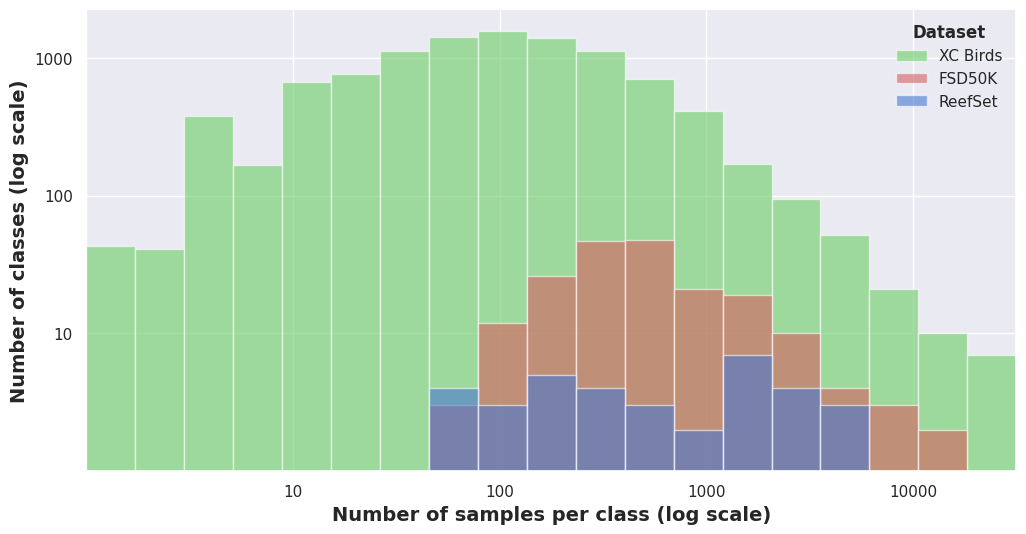

In [123]:
#@title Log both axis
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import seaborn as sns
import pandas as pd
import os

# Load the csvs's containg counts per class for each dataset
bird_file_path = os.path.join(base_dir, 'ucl_perch/other/label_sounts/bird_label_counts.csv')
bird_data = pd.read_csv(bird_file_path)

fsd50k_file_path = os.path.join(base_dir, 'ucl_perch/other/label_sounts/fsd50k_label_counts.csv')
fsd50k_data = pd.read_csv(fsd50k_file_path)

reef_file_path = os.path.join(base_dir, 'ucl_perch/other/label_sounts/reef_label_counts.csv')
reef_data = pd.read_csv(reef_file_path)

# Set up the aesthetic parameters for a visually appealing plot
sns.set(style="darkgrid", palette="muted", color_codes=True)

plt.figure(figsize=(12, 6))

# Define custom bins for the log scale.
bins = np.logspace(np.log10(1), np.log10(bird_data['Count'].max()), 20)

# Plotting each dataset using matplotlib directly with log scale
plt.hist(bird_data['Count'], bins=bins, color="g", label='XC Birds', alpha=0.6)
plt.hist(fsd50k_data['Count'], bins=bins, color="r", label='FSD50K', alpha=0.6)
plt.hist(reef_data['Count'], bins=bins, color="b", label='ReefSet', alpha=0.6)

# Apply log scaling on both axes
plt.xscale('log')
plt.yscale('log')

# Customize tick labels to remove 10^0
ax = plt.gca()  # Get current axes

# Set formatter for the x-axis
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x:g}' if x != 1 else ''))

# Set formatter for the y-axis
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: f'{y:g}' if y != 1 else ''))


# Setting up the labels
plt.xlabel('Number of samples per class (log scale)', fontsize=14, fontweight='bold')
plt.ylabel('Number of classes (log scale)', fontsize=14, fontweight='bold')

# Modify legend: remove border and make title bold
legend = plt.legend(title='Dataset', frameon=False)
plt.setp(legend.get_title(), fontweight='bold')
plt.xlim(left=1, right=bird_data['Count'].max())
plt.ylim(bottom=1) # set to start at 1

plt.show()

# Map figure

/tmp/ipykernel_743/294594272.py:25: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


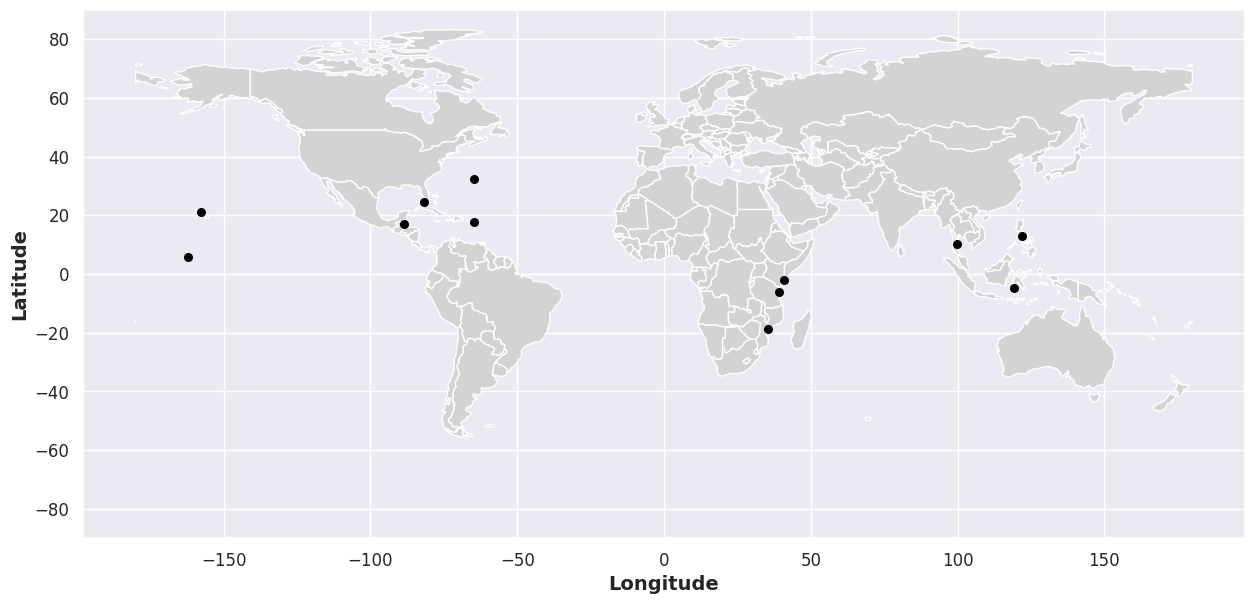

In [125]:
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from shapely.geometry import Point

# Data preparation
data = {
    'Location': ['Florida Keys', 'Hawaii', 'Palmyra Atoll', 'Bermuda', 'Belize', 'Philippines', 
                 'Spermonde, Indonesia', 'Mozambique', 'US Virgin Islands, Butler Bay', 
                 'Tanzania, Zanzibar', 'Thailand, Kho Tao', 'Kenya, Manda Bay'],
    'Latitude': [24.559688, 21.3, 5.9, 32.307800, 17.189877, 13.0, -4.8756, -18.665695, 17.7296, 
                 -6.1659, 10.0956, -2.1610],
    'Longitude': [-81.784404, -157.8, -162.1, -64.750500, -88.497650, 122.0, 119.1144, 35.529562, 
                  -64.89, 39.2026, 99.8404, 41.0277],
    'Datasets': [2, 2, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1]
}

# Convert to GeoDataFrame
gdf = gpd.GeoDataFrame(
    data, 
    geometry=[Point(xy) for xy in zip(data['Longitude'], data['Latitude'])]
)

# World basemap
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Clipping the world map to the specified latitude range
world_clipped = world.cx[:, -60:60]

# Plot
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
world_clipped.plot(ax=ax, color='lightgrey')#, edgecolor='black')  # Background color

# Set the y-limits (latitude) of the map to -50 to 50
ax.set_ylim(-90, 90)

# Adjust marker size for the plot here
marker_size_on_plot = 30  # Adjust this value as needed

# Plotting points with thicker black outlines
gdf[gdf['Datasets'] == 1].plot(ax=ax, color='black', marker='o', markersize=marker_size_on_plot, 
                               label='1 Dataset', edgecolor='black', linewidth=1)
gdf[gdf['Datasets'] == 2].plot(ax=ax, color='black', marker='o', markersize=marker_size_on_plot, 
                               label='2 Datasets', edgecolor='black', linewidth=1)

# Custom legend with smaller marker size for clarity
#legend_labels = {1: 'One', 2: 'Two'}
markers = [mlines.Line2D([], [], color=color, marker='o', linestyle='None', markersize=8, 
                         markeredgewidth=1, markeredgecolor='black') for color in ['orange', 'pink']]
#legend = plt.legend(markers, [legend_labels[l] for l in legend_labels.keys()], title='Number of datasets \n in region')

# Centering the text in the title of the legend
#legend.get_title().set_ha('center')

# Title and labels
#plt.title('Location of 16 coral reef datasets')
plt.xlabel('Longitude', fontsize=14, fontweight='bold')
plt.xticks(fontsize=12)
plt.ylabel('Latitude',fontsize=14, fontweight='bold')
plt.yticks(fontsize=12)


# Show plot
plt.show()

Made belize pie chart


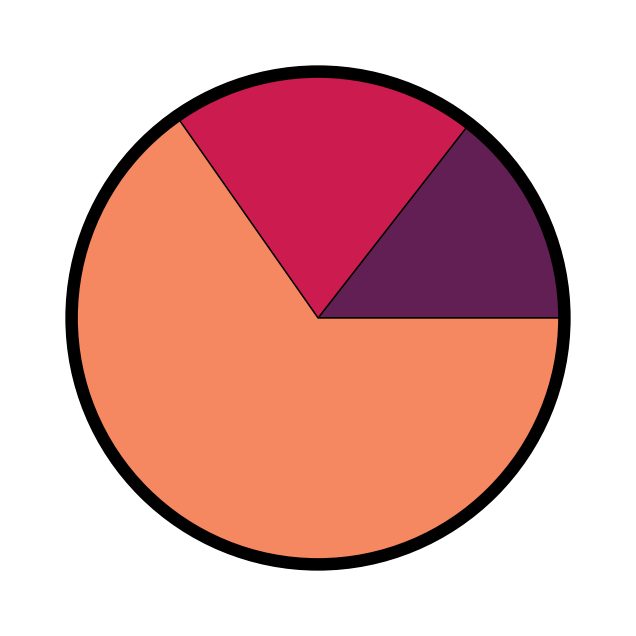

Made bermuda pie chart


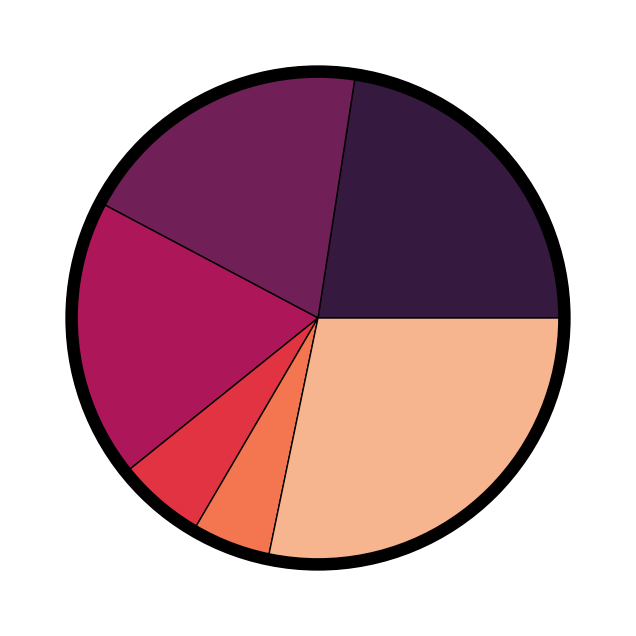

Made florida_boats pie chart


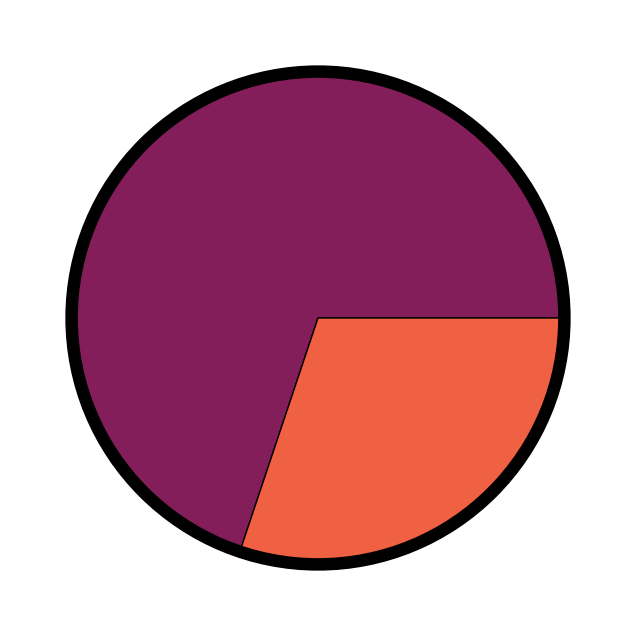

Made florida_cmi pie chart


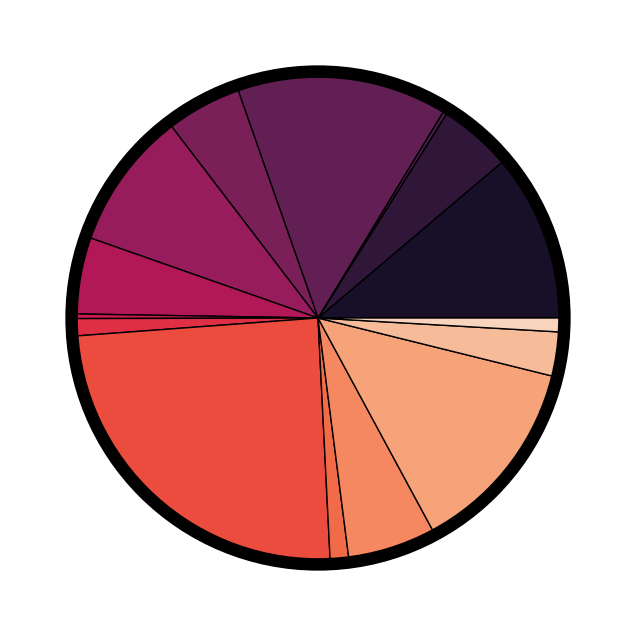

Made hawaii_himb pie chart


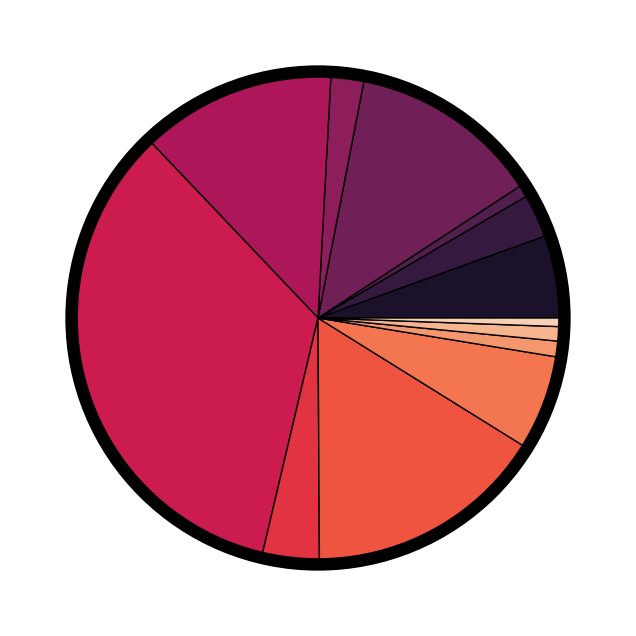

Made hawaii_kaneohe pie chart


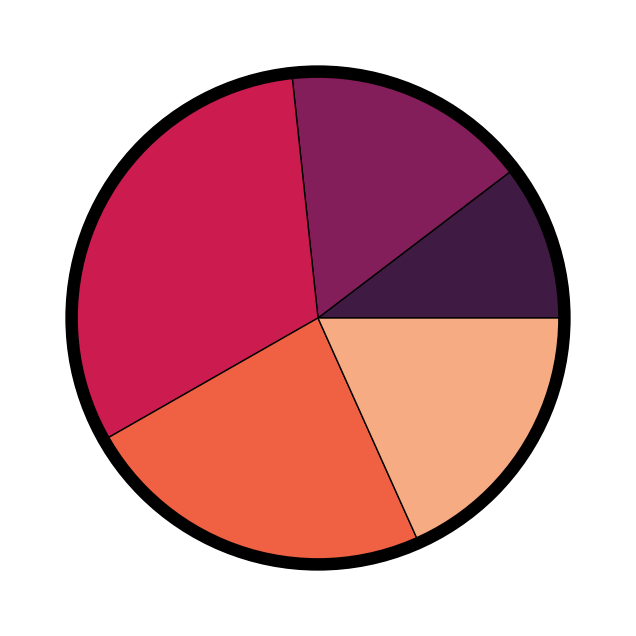

Made indonesia_bombs pie chart


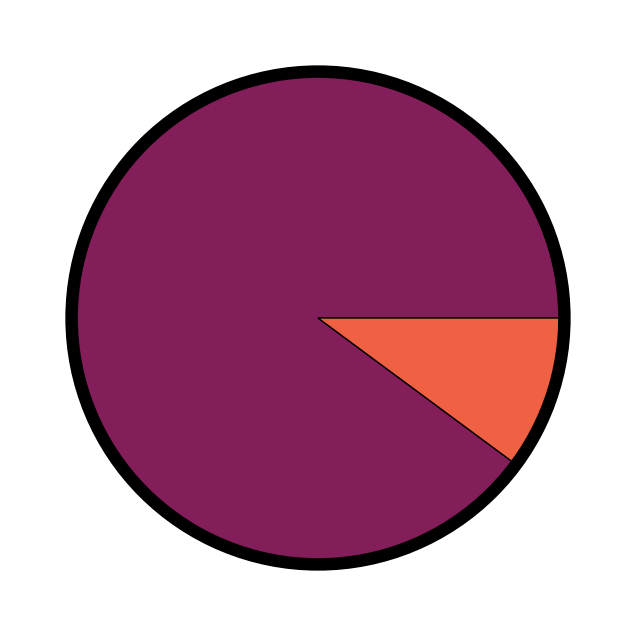

Made kenya pie chart


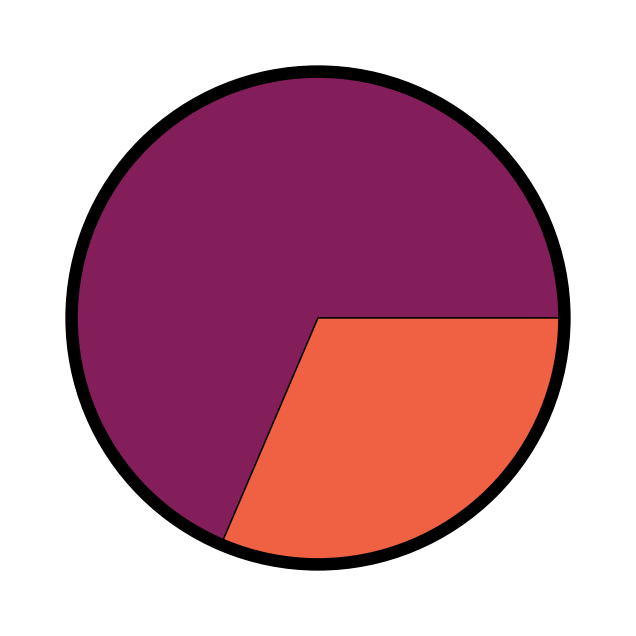

Made mozambique pie chart


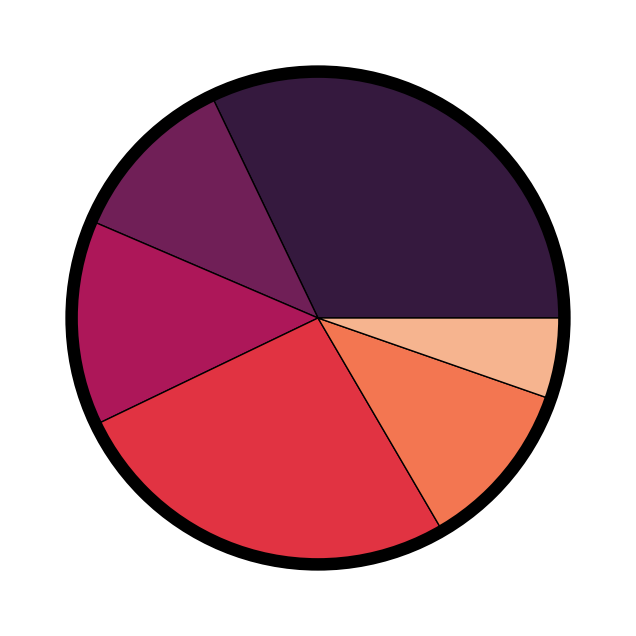

Made palmyra_hydromoth pie chart


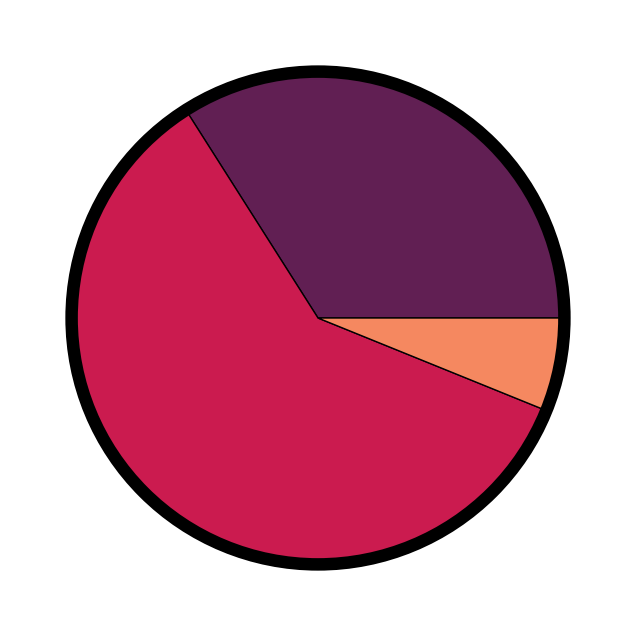

Made palmyra_other pie chart


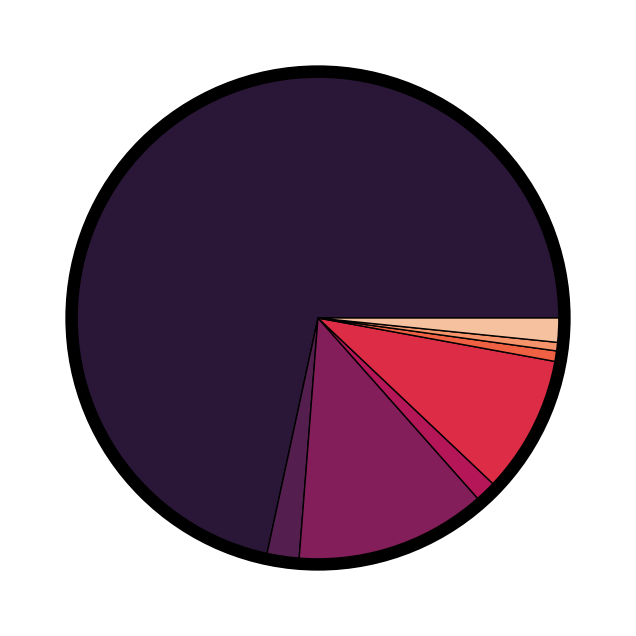

Made philippines_cmi pie chart


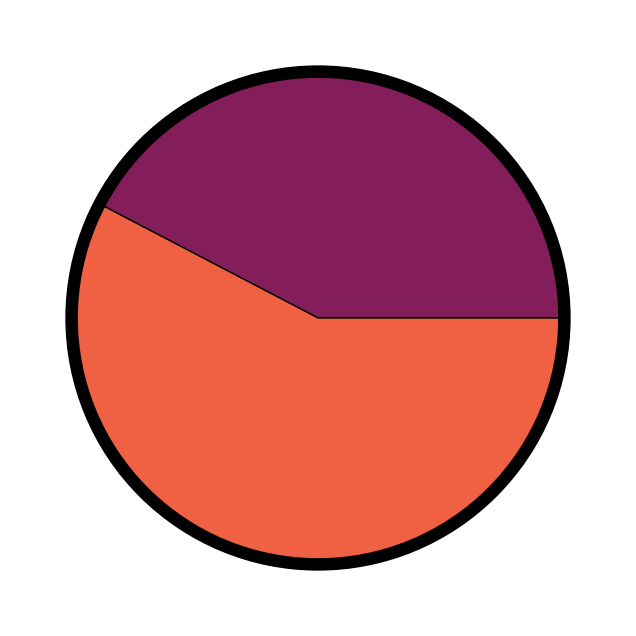

Made tanzania pie chart


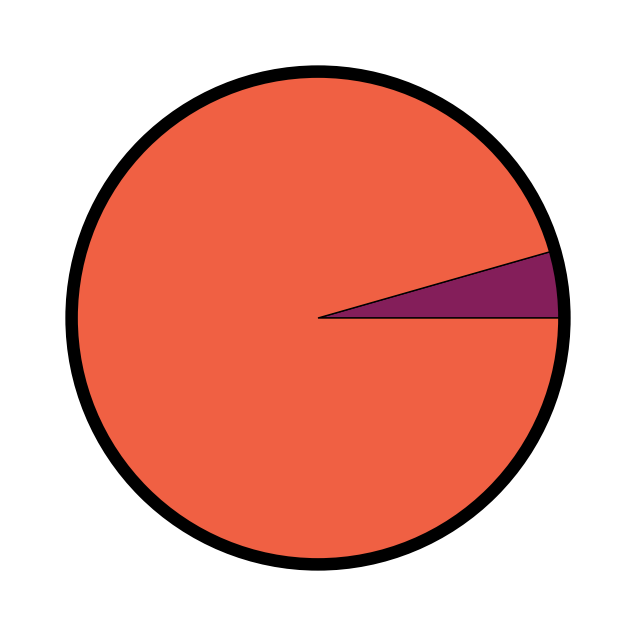

Made thailand pie chart


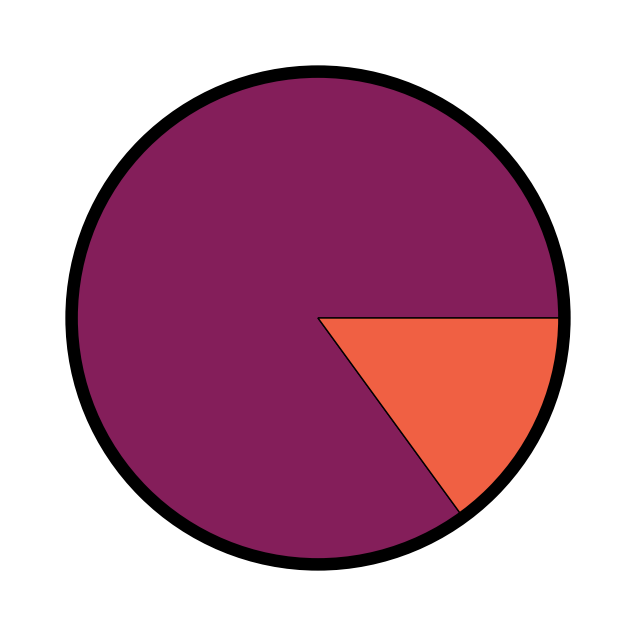

Made usvi_butler-bay pie chart


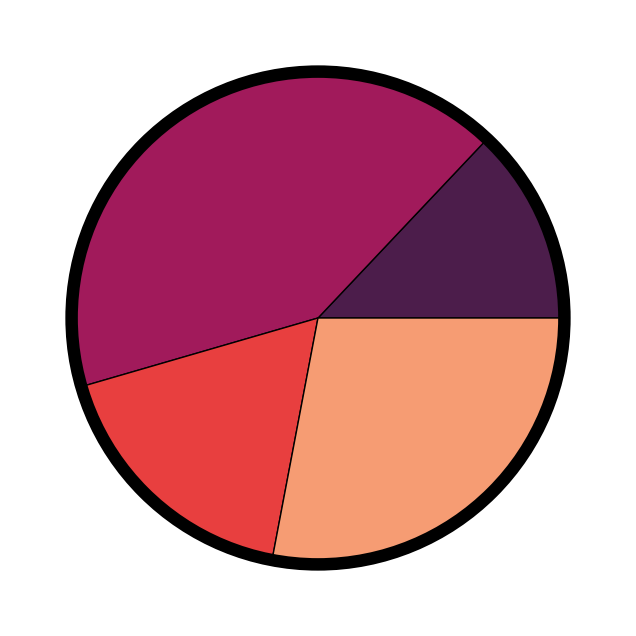

Made usvi_stcroix pie chart


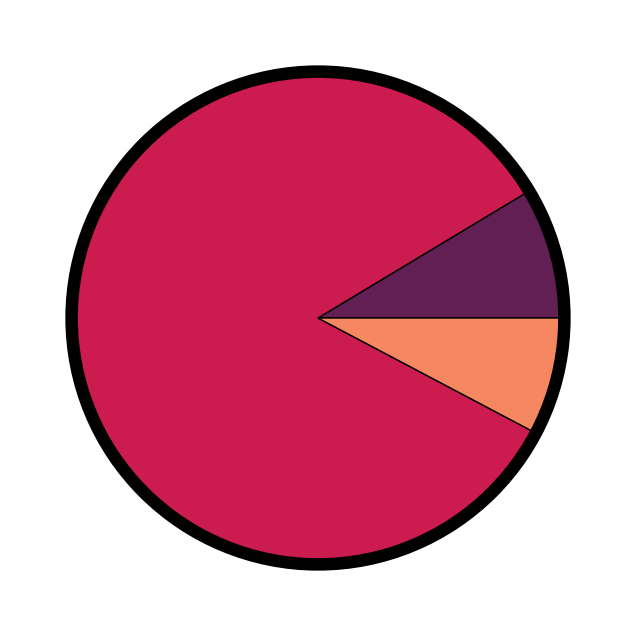

In [25]:
for region in pivot_table.columns:
    # Specify the region column dynamically
    region_column = region  # Change this as needed for different regions

    # Filter out labels with value 0 for the specified region
    filtered_data = pivot_table[region_column][pivot_table[region_column] > 0]

    # Set up the plot
    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(aspect="equal"))
    fig.patch.set_facecolor('none')  # No background color
    fig.patch.set_alpha(0)  # Transparent background

    # Palette
    palette = sns.color_palette('rocket', len(filtered_data))

    # Plot the pie chart without labels or percentages
    wedge_properties = {'linewidth': 1, 'edgecolor': 'black'}  # Internal dividers thinner
    ax.pie(filtered_data, startangle=0, colors=palette, wedgeprops=wedge_properties)

    # Add a thicker circle at the edge for emphasis
    circle = plt.Circle((0, 0), 1, color='black', fill=False, linewidth=9)  # Adjust linewidth for thickness
    ax.add_artist(circle)

    # Save the figure without background
    output_filename = f"pie_{region_column}.png"  # Save as PNG
    output_path = os.path.join(base_dir, 'ucl_perch/other/figures', output_filename)
    plt.savefig(output_path, bbox_inches='tight', transparent=True)
    print(f'Made {region} pie chart')

    # Show the plot
    plt.show()